# Analysing Twitter Data on Insomnia

This is my third-year Computer Science project at the University of Manchester. 

This notebook contains the code to do various experiments on existing tweets 
file. 

The code was developed using the **Google Colab** platform.

## Dataset
There are three classes for sentiments - 0: Negative, 1: Neutral, 2: Positive. 

The structure of the annotated json file for each item in the array: 1) Publish Date, 2) Location, 3) Tweet, 4) Sentiment.  

## Essential Things to Have to Run this Notebook
1. Set the **BASE_PATH** which is the project directory to access the dataset.
2. Make sure you have json (or at least csv) file which consists of tweets on insomnia. If not, then you can firstly run **TweetCollector** notebook to collect tweets. You can update the names of files in the **Define Constants** section if preferred.
3. If you want to use spelling correction and expand the dictionary, then check out for more details in the **Text Pre-Processing section**.
4. To be able to run Fine-Tuned transformer model, you need firstly to have one already trained and stored in the provided directory. It can also be trained and saved with my provided notebook **TweetTransformerTraining**. 
5. To do analysis of topic and sentiment prediced tweets, you need to have two datasets: 1) one has to be labelled with topics which can be done using the notebook **TweetTopicModelling**, 2) second has to have predicted sentiments which can be done with the notebook **TweetTransformerTraining**. Those datasets should have the same tweets in the same order in both files. The names for files can be found in the **Define Constants section**.

## Notebook Tasks

1. Defines text preprocessing functions which can be used to clean tweets and observe how different preprocessing (e.g. spelling correction, abbreviations/slang replacement) can affect Sentiment Analysis model results. 
2. Examines the annotated dataset, gives statistics of sentiment distribution, give observations. Compares objective and subjective (TextBlob library is used to filter those) tweets.
3. Gives sentiments prediction by three baseline methods: 1) TextBlob Patterns, 2) TextBlob Naive Bayes, 3) VADER. They will be used to compare results with other solutions.
4. Does oversampling with VADER to select tweets of some predicted class to reduce class imbalance in the annotated dataset. 
5. Load trained transformer model to do inference on tweets.
6. Analyse tweet sentiment consistency across the tweet by splitting the text either half or by contrasting conjunctions. 
7. Analyse sentiment count distribution over time for both all and subjective tweets to search for any patterns or spikes. 
8. Examine sentiment count distribution over time for labelled topics tweets. 

© 2023 Lukas Rimkus 

# Connect to the Google Drive

Firstly, connect to the Google Drive to be able to access files from there to read and store tweets.

If other platform is used to run the notebook code, then comment this out. 

In [1]:
from google.colab import drive, files

colab_path = '/content/drive'
drive.mount(colab_path)

Mounted at /content/drive


# Install and Import Required Libraries for Tweets Topic Modelling

In [2]:
#@title Install Libraries
!pip install emoji
!pip install transformers

!python -m textblob.download_corpora

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.9/240.9 KB 9.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-2.2.0-py3-none-any.whl size=234926 sha256=7290c6f95977d46b3b590888c512f54f8f6a5eab66fdced3e7f3d500fcd983d9
  Stored in directory: /root/.cache/pip/wheels/9a/b8/0f/f580817231cbf59f6ade9fd132ff60ada1de9f7dc85521f857
Successfully built emoji
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 47.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 56.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 20.8 MB/s eta 0:00:00
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt to /root/nltk_data.

## Import Libraries

In [3]:
import os
import re
import time
from datetime import datetime
import json

from collections import Counter
import emoji

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import TweetTokenizer, WhitespaceTokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, precision_score, recall_score, ConfusionMatrixDisplay

from textblob import TextBlob, Blobber
from textblob.sentiments import NaiveBayesAnalyzer, PatternAnalyzer
import textblob

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler, Sampler, random_split

import plotly.express as px

# Contractions and Abbreviations Maps 

I defined contractions and abbreviations/slang maps here. They can be used during the Pre-processing process of tweets.

The list of contractions was taken from [here](https://github.com/kootenpv/contractions/blob/master/contractions/data/contractions_dict.json), but I added some more after experimentation.

The list of abbreviations was taken from [here](https://www.kaggle.com/code/nmaguette/up-to-date-list-of-slangs-for-text-preprocessing/notebook), but as I was analysing tweet I added more of them after taking definitions from the [Urban Dictionary](https://www.urbandictionary.com/). 

In [4]:
#@title MAPS

CONTRACTIONS = {
    "I'm": "I am",
    "I'm'a": "I am about to",
    "I'm'o": "I am going to",
    "I've": "I have",
    "I'll": "I will",
    "I'll've": "I will have",
    "I'd": "I would",
    "I'd've": "I would have",
    "Whatcha": "What are you",
    "amn't": "am not",
    "ain't": "are not",
    "aren't": "are not",
    "'cause": "because",
    "can't": "cannot",
    "can't've": "cannot have",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "daren't": "dare not",
    "daresn't": "dare not",
    "dasn't": "dare not",
    "didn't": "did not",
    "didn’t": "did not",
    "don't": "do not",
    "don’t": "do not",
    "doesn't": "does not",
    "e'er": "ever",
    "everyone's": "everyone is",
    "finna": "fixing to",
    "gimme": "give me",
    "gon't": "go not",
    "gonna": "going to",
    "gotta": "got to",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he've": "he have",
    "he's": "he is",
    "he'll": "he will",
    "he'll've": "he will have",
    "he'd": "he would",
    "he'd've": "he would have",
    "here's": "here is",
    "how're": "how are",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how's": "how is",
    "how'll": "how will",
    "isn't": "is not",
    "it's": "it is",
    "'tis": "it is",
    "'twas": "it was",
    "it'll": "it will",
    "it'll've": "it will have",
    "it'd": "it would",
    "it'd've": "it would have",
    "kinda": "kind of",
    "let's": "let us",
    "luv": "love",
    "ma'am": "madam",
    "may've": "may have",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "ne'er": "never",
    "o'": "of",
    "o'clock": "of the clock",
    "ol'": "old",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "o'er": "over",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shalln't": "shall not",
    "shan't've": "shall not have",
    "she's": "she is",
    "she'll": "she will",
    "she'd": "she would",
    "she'd've": "she would have",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so is",
    "somebody's": "somebody is",
    "someone's": "someone is",
    "something's": "something is",
    "sux": "sucks",
    "that're": "that are",
    "that's": "that is",
    "that'll": "that will",
    "that'd": "that would",
    "that'd've": "that would have",
    "em": "them",
    "there're": "there are",
    "there's": "there is",
    "there'll": "there will",
    "there'd": "there would",
    "there'd've": "there would have",
    "these're": "these are",
    "they're": "they are",
    "they've": "they have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they'd": "they would",
    "they'd've": "they would have",
    "this's": "this is",
    "this'll": "this will",
    "this'd": "this would",
    "those're": "those are",
    "to've": "to have",
    "wanna": "want to",
    "wasn't": "was not",
    "we're": "we are",
    "we've": "we have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we'd": "we would",
    "we'd've": "we would have",
    "weren't": "were not",
    "what're": "what are",
    "what'd": "what did",
    "what've": "what have",
    "what's": "what is",
    "what'll": "what will",
    "what'll've": "what will have",
    "when've": "when have",
    "when's": "when is",
    "where're": "where are",
    "where'd": "where did",
    "where've": "where have",
    "where's": "where is",
    "which's": "which is",
    "who're": "who are",
    "who've": "who have",
    "who's": "who is",
    "who'll": "who will",
    "who'll've": "who will have",
    "who'd": "who would",
    "who'd've": "who would have",
    "why're": "why are",
    "why'd": "why did",
    "why've": "why have",
    "why's": "why is",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "you're": "you are",
    "you've": "you have",
    "you'll've": "you shall have",
    "you'll": "you will",
    "you'd": "you would",
    "you'd've": "you would have",
}

ABBREVIATIONS = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "abt": "about",
    "acct" : "account",
    "adih" : "another day in hell",
    "'aight": "alright",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "ai": "artificial intelligence",
    "altho": "although",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "avg": "average",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "bc": "because",
    "bday": "birthday",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "cos": "because",
    "coz": "because",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "convo": "conversation",
    "convos": "conversations",
    "cuz": "because",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diff": "different",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dunno": "do not know",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "finna": "going to",
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "g'day": "good day",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gimme": "give me",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gonna": "going to",
    "gotta": "got to",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "howdy": "how do you do",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "ima": "I am going to",
    "imma": "I am going to",
    "imu" : "i miss you",
    "innit": "is it not",
    "iow" : "in other words",
    "iunno": "I do not know",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "k": "okay",
    "kinda": "kind of",
    "kk": "okay",
    "kms": "kill myself",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lemme": "let me",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "meds": "medicines",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "msg": "message",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvm": "nevermind",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "ofc": "of course",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "probs": "probably",
    "prolly": "probably",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "pymnt": "payment",
    "qpsa" : "what happens", #"que pasa",
    "r ": "are ",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rly": "really",
    "rlly": "really",
    "rlrt" : "real life retweet", 
    "rn" : "right now",
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "sorta" : "sort of",
    "spk": "spoke",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tlked": "talked",
    "tmb" : "tweet me back",
    "tmmw": "tomorrow",
    "tmr": "tomorrow",
    "tmrw": "tomorrow",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "ur": "you are",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wanna": "want to",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "woulda": "would have",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

# Define Constants, Objects and Configurations

This is required for Vader Sentiment Analyser.

In [5]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

**Change BASE_PATH to your own location on Google Drive**.

In [6]:
BASE_PATH = "/content/drive/MyDrive/Third Year Project"

json_file_name = "data.json"
annotated_tweets_file_name = "annotated_tweets.json"
predicted_tweets_file_name = "predictions_data.json"
predicted_topics_tweets_file_name = "predictions_topics_data.json"
topics_file_name = "topic_modelling_tweets.json"  

json_file_path = f"{BASE_PATH}/{json_file_name}"  # this contains all collected tweets
annotated_tweets_file_path = f"{BASE_PATH}/{annotated_tweets_file_name}"  # this contains tweets with human annotations
predicted_tweets_file_path = f"{BASE_PATH}/{predicted_tweets_file_name}"  # this contains the whole tweets dataset with predicted sentiments 
predicted_topics_tweets_file_path = f"{BASE_PATH}/{predicted_topics_tweets_file_name}"  # this contains data about tweet topics and predicted sentiments
save_topic_tweets_paths = f"{BASE_PATH}/{topics_file_name}"  # this contains tweets used for training BERTopic model

sentiment_labels = {"NEGATIVE": 0, "NEUTRAL": 1, "POSITIVE": 2}

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 1500)
pd.set_option('mode.chained_assignment', None)

# Text Pre-Processing 

## Increase the Size of the TextBlob Speller Dictionary

I found that TextBlob has a very small dictionary of words. This was the reason why I kept getting quite mediocre results, thus I added dictionary from [Symspell library](https://github.com/mammothb/symspellpy) which is more comprehensive. 

However, it is a text file, so firstly I converted it to a json file which can be used to update a dictionary. However, I do need to convert whole my text to lowercase. 

I chose to do this, not to use another spell checking library because other libraries have much bigger limitations: 
1. pyspellchecker and Symspellpy only can be used for a single word (otherwise they may remove punctuation and other characters like emoji) which is not what I want here. Whereas TextBlob speller does not have such problems. 
2. ContextualSpellCheck takes context into account but this does not work here properly because certain words are replaced as they fit better in 'context'. I want to retain words written by users which I am using for analysis without changing significantly the semantics of tweets.

To use it, uncomment the line at the bottom. However, **freq_dictionary.json** or **freq_dictionary.txt** are needed to have in the project directory. But **this is not used by default in the experiments**, so not necessary to work on making this to work.   

In [7]:
def load_dictionary():
    """
    This method updates the dictionary of TextBlob Speller using the 'freq_dictionary.txt'
    file from Symspellpy.
    """
    json_dictionary_path = f"{BASE_PATH}/freq_dictionary.json"
    json_file_exists = os.path.exists(json_dictionary_path)
    dictionary = dict()

    if not json_file_exists:
        text_dictionary_path = f"{BASE_PATH}/freq_dictionary.txt"
        txt_file_exists = os.path.exists(text_dictionary_path)

        if txt_file_exists:
            with open(text_dictionary_path, "r") as input_file:
                lines = input_file.readlines()
                
                for line in lines:
                    cleaned_line = line.strip()
                    word, freq = cleaned_line.split()
                    dictionary[word] = int(freq)

                textblob.en.spelling.update(dictionary)

                # Save the txt file in json
                with open(json_dictionary_path, 'w') as output_file:
                    json.dump(dictionary, output_file)
        else:
            print("Please upload a dictionary file!")

    else:   
        with open(json_dictionary_path, "r") as input_file:
            dictionary = json.load(input_file)
            textblob.en.spelling.update(dictionary)


# load_dictionary()

## TextPreProcessor Class Definition

Created the TextPreProcessor class which contains various ways of processing data before doing Sentiment Analysis with transformers. These can be used to alter tweets for training models to see if these preprocessing methods help or decrease the performance. 

In [8]:
class TextPreProcessing: 
    @staticmethod
    def remove_emoji(text: str) -> str:
        """
        This method removed emojis from the piece of text. 
        Taken from: https://www.kaggle.com/code/quentinsarrazin/tweets-preprocessing/notebook
        """
        emoji_pattern = re.compile("["
                            u"\U0001F600-\U0001F64F"  # emoticons
                            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                            u"\U0001F680-\U0001F6FF"  # transport & map symbols
                            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                            u"\U00002702-\U000027B0"
                            u"\U000024C2-\U0001F251"
                            "]+", flags=re.UNICODE)
        return emoji_pattern.sub(r'', text)

    @staticmethod
    def remove_non_ascii_characters(text: str) -> str:
        """
        This method removes non-ASCII characters from the text.
        It has a document as string parameter.
        Returns a document with removed non-ASCII characters which are replaced by a space.
        """
        # Without an added space, the words could be merged together to one, which is unwanted.
        text = re.sub(r'[^\x00-\x7F]+',' ', text)
        return text

    @staticmethod
    def remove_non_alpha_characters(text: str) -> str:
        """
        This method removes non alpha characters from the given text.
        """
        pattern = r'[^a-zA-z\s]'
        text = re.sub(pattern, '', text)
        return text
            
    @staticmethod
    def expand_contractions(text: str) -> str:
        """
        This method replaces contractions in the document text using a contraction map
        which is taken from a library on github repository. 

        It has a document as string parameter.
        Returns a document with replaced contraction equivalents.
        """
        
        # Split the document to tokens separated by a space.  
        words = text.split()

        for i, word in enumerate(words):
            if word.lower() in CONTRACTIONS:
                words[i] = CONTRACTIONS[word.lower()]

        return " ".join(words)

    @staticmethod
    def replace_emoji_with_text(text: str) -> str:
        """
        Replace emojis of its English text equivalents using the emoji library.
        https://github.com/carpedm20/emoji
        """

        emojis = emoji.distinct_emoji_list(text)

        for emoji_symbol in emojis:
            emoji_text = emoji.demojize(emoji_symbol)
            cleaned_emoji_text = emoji_text[1:-1].replace("_", " ")
            text = text.replace(emoji_symbol, cleaned_emoji_text)
        
        return text

    @staticmethod
    def replace_abbreviations(text: str) -> str:
        """
        Replace abbreviations in string of text
        """
        words = re.split('(\W+?)', text)

        for i, word in enumerate(words):
            if word.isalpha():
                if word.lower() in ABBREVIATIONS:
                    words[i] = ABBREVIATIONS[word.lower()]
        
        return "".join(words)

    @staticmethod
    def correct_tweet(tweet: str) -> str:
        """
        This method makes tweets lowercase, replaces abbreviations, expands contractions and 
        finally applies spelling correction. 
        I need to make it lowercase because the TextBlob spelling corrector may try to 
        correct tweets which are uppercase as they are not probably in the dictionary
        """
        tweet = tweet.lower()
        tweet = TextPreProcessing.replace_abbreviations(tweet)
        tweet = TextPreProcessing.expand_contractions(tweet)
        tweet_blob = TextBlob(tweet)
        tweet_blob = tweet_blob.correct()

        return str(tweet_blob)

In [9]:
TextPreProcessing.correct_tweet("I'm goingg homw bc my mom needs meds form pharmacy argentlly. Alsp, I need to buu melatonin and Ambien for lseeping")

"i'm going how because my mon needs medicines form pharmacy urgently. also, i need to but melanin and alien for sleeping"

# Exploratory Data Analysis



## Read the Tweets Dataset

In [10]:
def read_json_dataset(json_path: str) -> tuple:
    """
    This method checks if there exists a json file at the given path. If it exists, 
    then it is read and consequently returned.
    """
    file_exists = os.path.exists(json_path)
    if not file_exists:
        print(f"There is no file at: {json_path}")
        return False, None

    # Read the dataset
    tweets_df = pd.read_json(json_path, orient="records")

    return True, tweets_df


def open_json_file(file_path: str) -> pd.DataFrame:
    """
    This method calls the method 'read_json_dataset' and is an abstraction of that 
    method to read and return json files of tweets. 
    """
    success, tweets_df = read_json_dataset(file_path)
    if not success:
        return
    
    return tweets_df

In [11]:
tweets_df = open_json_file(annotated_tweets_file_path)
tweets_df.head()

,Publish Date,Location,Tweet,Sentiment
0,1673529293000,WA,I feel. Even melatonin won’t help 😩,0
1,1672724214000,,Can't sleep so ask me stuff url,1
2,1674133015000,yaaay areaaa,These sleepless nights are catching up,1
3,1673892049000,Her DM,I read that chat 4 times 😍💕\nSleeping pill\n\nGood Night,2
4,1675290996000,,"“ It's a pleasure, it will mean that I will hold you in my arms all the nights you can't sleep. What about Netflix? great invention! ”\n\nHe took her to the bed and they sat there, both embracing as they went to turn on the TV.",2


In [12]:
number_of_tweets = len(tweets_df)
print(f"Nmber of tweets: {number_of_tweets}")
tweets_df['Sentiment'].value_counts()

Nmber of tweets: 1008


1    353
0    351
2    304
Name: Sentiment, dtype: int64

## Remove Unnecessary Columns



In [13]:
tweets_df.drop(columns=["Publish Date", "Location"], inplace=True)

##Correct Tweets

If you want to use tweets spelling correction, uncomment the line below. 

In [14]:
def do_tweets_preprocessing(tweets_df: pd.DataFrame) -> pd.DataFrame:
    tweets_df["Corrected Tweet"] = tweets_df["Tweet"].apply(lambda tweet: TextPreProcessing.correct_tweet(tweet))

    corrected_tweets_df = tweets_df[tweets_df["Tweet"] != tweets_df["Corrected Tweet"]]
    corrected_tweets_number = len(corrected_tweets_df)

    print(f"{corrected_tweets_number} tweets have been altered")
    return tweets_df


# do_tweets_preprocessing(tweets_df)

## Examine the Number of Tweets in each Class

In [15]:
tweets_df['Sentiment'].value_counts()

1    353
0    351
2    304
Name: Sentiment, dtype: int64

In [16]:
neutral_tweets_df = tweets_df[tweets_df["Sentiment"] == sentiment_labels["NEUTRAL"]]
neutral_tweets_number = len(neutral_tweets_df)
print(f"Neutral tweets count: {neutral_tweets_number}")
neutral_tweets_df.head()

Neutral tweets count: 353


,Tweet,Sentiment
1,Can't sleep so ask me stuff url,1
2,These sleepless nights are catching up,1
7,Wordle 550 2/6\n\n🟨🟨🟩⬛⬛\n🟩🟩🟩🟩🟩\n\nInsomnia wins the day!,1
8,we should go mimis lemme take melatonin 🏃🏃,1
9,It's like a sleeping pill for me 😩,1


In [17]:
negative_tweets_df = tweets_df[tweets_df["Sentiment"] == sentiment_labels["NEGATIVE"]]
negative_tweets_number = len(negative_tweets_df)
print(f"Negative tweets count: {negative_tweets_number}")
negative_tweets_df.head()

Negative tweets count: 351


,Tweet,Sentiment
0,I feel. Even melatonin won’t help 😩,0
5,I have exactly the same. And nothing helps. If you find some way to cure insomnia I'd love to know it 😉 .,0
6,I’m currently doing homemade bone broth and lions mane powder that i mix up with a stick frother 🤣 I tried for the last year to make coffee work for me and I can’t! Gives me zero energy thru the day but then I can’t sleep! Tried teas and shit lol I need a fuckin stimmy! Lol url,0
10,12:44 am and I can't sleep. Again.,0
14,insomnia keeps my mind up all night fightin the demons from my past that just won’t go away 🤦🏿‍♂️,0


In [18]:
positive_tweets_df = tweets_df[tweets_df["Sentiment"] == sentiment_labels["POSITIVE"]]
positive_tweets_number = len(positive_tweets_df)
print(f"Positive tweets count: {positive_tweets_number}")
positive_tweets_df.head()

Positive tweets count: 304


,Tweet,Sentiment
3,I read that chat 4 times 😍💕\nSleeping pill\n\nGood Night,2
4,"“ It's a pleasure, it will mean that I will hold you in my arms all the nights you can't sleep. What about Netflix? great invention! ”\n\nHe took her to the bed and they sat there, both embracing as they went to turn on the TV.",2
12,Please do it would really help my insomnia. Thanks gorgeous 😍,2
13,i love baby melatonin gummies,2
15,"I’ve been using nose strips to sleep with and it’s been a total game changer\n\nNo more melatonin, weed, or supplements of any kind\n\nJust quick, easy, high quality sleep",2


## Subjectivity Analysis

With the use of the TextBlob library, subjectivity analysis is used to filter out tweets which are highly objective as tweets with personal experiences are needed. 


In [19]:
def filter_subjective_tweets(tweets_df, threshold):
    """
    This method removes tweets which are considered to not be subjective. It is done 
    using TextBlob subjectivity property which gives values [0, 1] where 1 is highly 
    subjective. Through experimentation, I chose to use a threshold of 0.1 for tweets  
    to be preserved in the dataframe.
    """
    number_of_original_tweets = len(tweets_df)

    subjectivities = np.zeros(number_of_original_tweets)

    for i, tweet in enumerate(tweets_df["Tweet"]):
        tweet_blob = TextBlob(tweet)
        subjectivity = tweet_blob.subjectivity
        
        subjectivities[i] = subjectivity

    tweets_df["Subjectivity"] = subjectivities

    subjective_tweets_df = tweets_df[tweets_df["Subjectivity"] > threshold]
    objective_tweets_df = tweets_df[tweets_df["Subjectivity"] <= threshold]

    return tweets_df, subjective_tweets_df, objective_tweets_df

In [20]:
threshold = 0.1
tweets_df, subjective_tweets_df, objective_tweets_df = filter_subjective_tweets(tweets_df, threshold)

## Analysing Subjective Tweets Sentiments

In [21]:
subjective_tweets_df['Sentiment'].value_counts()

2    262
0    236
1    157
Name: Sentiment, dtype: int64

In [22]:
subjective_tweets_number = len(subjective_tweets_df)
subjective_neutral_tweets = len(subjective_tweets_df[subjective_tweets_df['Sentiment'] == sentiment_labels["NEUTRAL"]])
subjective_negative_tweets = len(subjective_tweets_df[subjective_tweets_df['Sentiment'] == sentiment_labels["NEGATIVE"]])
subjective_positive_tweets = len(subjective_tweets_df[subjective_tweets_df['Sentiment'] == sentiment_labels["POSITIVE"]])

print(f"Overall Subjective tweets number: {subjective_tweets_number}")
print(f"Subjective Neutral tweets number: {subjective_neutral_tweets}")
print(f"Subjective Negative tweets number: {subjective_negative_tweets}")
print(f"Subjective Positive tweets number: {subjective_positive_tweets}")
subjective_tweets_df.head()

Overall Subjective tweets number: 655
Subjective Neutral tweets number: 157
Subjective Negative tweets number: 236
Subjective Positive tweets number: 262


,Tweet,Sentiment,Subjectivity
2,These sleepless nights are catching up,1,0.900000
3,I read that chat 4 times 😍💕\nSleeping pill\n\nGood Night,2,0.600000
4,"“ It's a pleasure, it will mean that I will hold you in my arms all the nights you can't sleep. What about Netflix? great invention! ”\n\nHe took her to the bed and they sat there, both embracing as they went to turn on the TV.",2,0.718750
5,I have exactly the same. And nothing helps. If you find some way to cure insomnia I'd love to know it 😉 .,0,0.325000
6,I’m currently doing homemade bone broth and lions mane powder that i mix up with a stick frother 🤣 I tried for the last year to make coffee work for me and I can’t! Gives me zero energy thru the day but then I can’t sleep! Tried teas and shit lol I need a fuckin stimmy! Lol url,0,0.533333


## Analysing Objective Tweets Sentiments

In [23]:
objective_tweets_df['Sentiment'].value_counts()

1    196
0    115
2     42
Name: Sentiment, dtype: int64

In [24]:
objective_tweets_number = len(objective_tweets_df)
objective_neutral_tweets = len(objective_tweets_df[objective_tweets_df['Sentiment'] == sentiment_labels["NEUTRAL"]])
objective_negative_tweets = len(objective_tweets_df[objective_tweets_df['Sentiment'] == sentiment_labels["NEGATIVE"]])
objective_positive_tweets = len(objective_tweets_df[objective_tweets_df['Sentiment'] == sentiment_labels["POSITIVE"]])

print(f"Overall Objective tweets number: {objective_tweets_number}")
print(f"Objective Neutral tweets number: {objective_neutral_tweets}")
print(f"Objective Negative tweets number: {objective_negative_tweets}")
print(f"Objective Positive tweets number: {objective_positive_tweets}")
objective_tweets_df.head()

Overall Objective tweets number: 353
Objective Neutral tweets number: 196
Objective Negative tweets number: 115
Objective Positive tweets number: 42


,Tweet,Sentiment,Subjectivity
0,I feel. Even melatonin won’t help 😩,0,0.0
1,Can't sleep so ask me stuff url,1,0.0
8,we should go mimis lemme take melatonin 🏃🏃,1,0.0
9,It's like a sleeping pill for me 😩,1,0.0
10,12:44 am and I can't sleep. Again.,0,0.0


## Statistics on Objective vs Subjective Tweets

In [25]:
print(f"Out of all tweets {subjective_tweets_number/number_of_tweets*100:.2f}% have been identified as subjective, while {objective_tweets_number/number_of_tweets*100:.2f}% - objective.")
print(f"Out of all neutral tweets (there are {neutral_tweets_number} of them) {subjective_neutral_tweets/neutral_tweets_number*100:.2f}% have been identified as subjective (there are {subjective_neutral_tweets} of them), while {objective_neutral_tweets/neutral_tweets_number*100:.2f}% - objective.")
print(f"Out of all negative tweets (there are {negative_tweets_number} of them) {subjective_negative_tweets/negative_tweets_number*100:.2f}% have been identified as subjective (there are {subjective_negative_tweets} of them), while {objective_negative_tweets/negative_tweets_number*100:.2f}% - objective.")
print(f"Out of all positive tweets (there are {positive_tweets_number} of them) {subjective_positive_tweets/positive_tweets_number*100:.2f}% have been identified as subjective (there are {subjective_positive_tweets} of them), while {objective_positive_tweets/positive_tweets_number*100:.2f}% - objective.")

Out of all tweets 64.98% have been identified as subjective, while 35.02% - objective.
Out of all neutral tweets (there are 353 of them) 44.48% have been identified as subjective (there are 157 of them), while 55.52% - objective.
Out of all negative tweets (there are 351 of them) 67.24% have been identified as subjective (there are 236 of them), while 32.76% - objective.
Out of all positive tweets (there are 304 of them) 86.18% have been identified as subjective (there are 262 of them), while 13.82% - objective.


# Evaluation Metrics for Sentiment Analysis

Functions used to display performance as a confusion matrix, classification report, etc. 

In [26]:
def print_metrics(true_labels: np.ndarray, predicted_labels: np.ndarray) -> None:
    """
    This method prints these model evaluation metrics: Accuracy, Precision, Recall and F1 Score. 
    """
    print(f"Accuracy: {accuracy_score(true_labels, predicted_labels):.4f}")
    print(f"Precision: {precision_score(true_labels, predicted_labels, average='macro'):.4f}")
    print(f"Recall: {recall_score(true_labels, predicted_labels, average='macro'):.4f}")
    print(f"F1 Score: {f1_score(true_labels, predicted_labels, average='macro'):.4f}")


def display_confusion_matrix(true_labels: np.ndarray, predicted_labels: np.ndarray) -> None:
    """
    This method takes true and predicted labels and plots a confusion matrix on that.
    """
    display_labels = ["Negative", "Neutral", "Positive"]

    cm = confusion_matrix(y_true=true_labels, y_pred=predicted_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)

    disp.plot(cmap=plt.cm.Blues)
    plt.show()


def display_classification_report(true_labels: np.ndarray, predicted_labels: np.ndarray) -> None:
    """
    This method prints the classification report for the given model's results.
    """
    labels = list(sorted(sentiment_labels.values()))
    print(classification_report(y_true=true_labels, y_pred=predicted_labels, labels=labels))
    
    
def display_model_performance_metrics(true_labels: np.ndarray, predicted_labels: np.ndarray) -> None:
    """
    This method prints various metrics for doing model final evaluation in terms of true and predicted labels.
    """
    print('Model Performance metrics:\n')
    print_metrics(true_labels=true_labels, predicted_labels=predicted_labels)

    print('\n\nModel Classification report:')
    display_classification_report(true_labels=true_labels, predicted_labels=predicted_labels)

    print('\n\nPrediction Confusion Matrix:')
    display_confusion_matrix(true_labels=true_labels, predicted_labels=predicted_labels)

# Making Predictions with Baselines

Three methods have been chosen as baseline methods for Sentiment Analysis: 
1. TextBlob Patterns
2. TextBlob Naive Bayes
3. VADER (Valence Aware Dictionary and sEntiment Reasoner) 

**TextBlob Polarities**: "The sentiment property returns a namedtuple of the form Sentiment(polarity, subjectivity). The polarity score is a float within the range [-1.0, 1.0]. The subjectivity is a float within the range [0.0, 1.0] where 0.0 is very objective and 1.0 is very subjective." ([source](https://textblob.readthedocs.io/en/dev/quickstart.html))


For **VADER** it is recommended to give sentiments by score as follows: positive sentiment: compound score >= 0.05; neutral sentiment: (compound score > -0.05) and (compound score < 0.05); negative sentiment: compound score <= -0.05 ([source](https://github.com/cjhutto/vaderSentiment)). 


In [27]:
def patterns_sentiment_analyser(tweets_df: pd.DataFrame, access_key="Tweet") -> pd.DataFrame:
    """
    This method makes use of TextBlob Patterns sentiment analyser to assign a tweet 
    to a certain class. 
    The resulting dataframe is returned. 
    """
    number_of_tweets = len(tweets_df)
    polarities, predictions = np.zeros(number_of_tweets), np.zeros(number_of_tweets)

    for i, tweet in enumerate(tweets_df[access_key]):
        tweet_blob = TextBlob(tweet)
        polarity = tweet_blob.polarity
        
        polarities[i] = polarity

        # Give positive
        if polarity >= 0.05:
            predictions[i] = sentiment_labels["POSITIVE"]

        # Give negative
        elif polarity <= -0.05:
            predictions[i] = sentiment_labels["NEGATIVE"]

        # Give neutral
        else:
            predictions[i] = sentiment_labels["NEUTRAL"]

    tweets_df.loc[:, "Patterns Polarity"] = polarities.copy()
    tweets_df.loc[:, "Patterns Predictions"] = predictions.copy()

    return tweets_df


def naive_bayes_sentiment_analyser(tweets_df: pd.DataFrame, access_key="Tweet") -> pd.DataFrame:
    """
    This method makes use of TextBlob Naive Bayes sentiment analyser to assign a tweet 
    to a certain class. 
    The resulting dataframe is returned. 
    """
    naive_bayes_blobber = Blobber(analyzer=NaiveBayesAnalyzer())
    number_of_tweets = len(tweets_df)

    positive, negative, predictions, classifications = np.zeros(number_of_tweets), np.zeros(number_of_tweets), np.zeros(number_of_tweets), np.empty(number_of_tweets, dtype=str)

    for i, tweet in enumerate(tweets_df[access_key]):
        blob = naive_bayes_blobber(tweet)
        sentiment = blob.sentiment
        pos, neg, classification = sentiment.p_pos, sentiment.p_neg, sentiment.classification
        positive[i], negative[i], classifications[i] = round(pos, 4), round(neg, 4), classification

        if positive[i] >= 0.6:
            predictions[i] = sentiment_labels["POSITIVE"]
        elif negative[i] >= 0.6:
            predictions[i] = sentiment_labels["NEGATIVE"]
        else:
            predictions[i] = sentiment_labels["NEUTRAL"]

    tweets_df.loc[:, "Naive Bayes"] = list(zip(positive.copy(), negative.copy(), classifications.copy()))
    tweets_df.loc[:, "Naive Bayes Predictions"] = predictions.copy()

    return tweets_df


def vader_sentiment_analyser(tweets_df: pd.DataFrame, access_key="Tweet") -> pd.DataFrame:
    """
    This method makes use of NLTK VADER sentiment analyser to assign a tweet 
    to a certain class. 
    The resulting dataframe is returned. 
    """
    vader_sentiment_analyser = SentimentIntensityAnalyzer()
    number_of_tweets = len(tweets_df)

    compound, predictions = np.zeros(number_of_tweets), np.zeros(number_of_tweets)

    for i, tweet in enumerate(tweets_df[access_key]):
        scores = vader_sentiment_analyser.polarity_scores(tweet)
        compound[i] = scores["compound"]
    
        if compound[i] >= 0.05:
            predictions[i] = sentiment_labels["POSITIVE"]
        elif compound[i] <= -0.05:
            predictions[i] = sentiment_labels["NEGATIVE"]
        else:
            predictions[i] = sentiment_labels["NEUTRAL"]

    tweets_df.loc[:, "VADER compound"] = compound.copy()
    tweets_df.loc[:, "VADER Predictions"] = predictions.copy()
    
    return tweets_df


def train_models(tweets_df: pd.DataFrame) -> pd.DataFrame:
    """
    This method makes use of TextBlob Patterns, TextBlob Naive Bayes and VADER sentiment analysers
    to assign a tweet to a certain class. These will be used for further data analysis.  
    The resulting dataframe of classifications by all sentiment analysers is returned. 
    """
    # If you used tweet spelling correction functions, then change it to "Corrected Tweet"
    access_key = "Tweet"

    tweets_df = patterns_sentiment_analyser(tweets_df.copy(), access_key)
    tweets_df = naive_bayes_sentiment_analyser(tweets_df.copy(), access_key)
    tweets_df = vader_sentiment_analyser(tweets_df.copy(), access_key)
    
    return tweets_df


In [28]:
trained_subjective_tweets_df = train_models(subjective_tweets_df)
trained_all_tweets_df = train_models(tweets_df)

In [29]:
trained_all_tweets_df.head()

,Tweet,Sentiment,Subjectivity,Patterns Polarity,Patterns Predictions,Naive Bayes,Naive Bayes Predictions,VADER compound,VADER Predictions
0,I feel. Even melatonin won’t help 😩,0,0.00000,0.00000,1.0,"(0.6427, 0.3573, p)",2.0,0.4019,2.0
1,Can't sleep so ask me stuff url,1,0.00000,0.00000,1.0,"(0.6057, 0.3943, p)",2.0,0.0000,1.0
2,These sleepless nights are catching up,1,0.90000,0.60000,2.0,"(0.8168, 0.1832, p)",2.0,0.0000,1.0
3,I read that chat 4 times 😍💕\nSleeping pill\n\nGood Night,2,0.60000,0.70000,2.0,"(0.3212, 0.6788, n)",0.0,0.4404,2.0
4,"“ It's a pleasure, it will mean that I will hold you in my arms all the nights you can't sleep. What about Netflix? great invention! ”\n\nHe took her to the bed and they sat there, both embracing as they went to turn on the TV.",2,0.71875,0.34375,2.0,"(0.7763, 0.2237, p)",2.0,0.8439,2.0


## Evaluation of Baseline Methods Results

Do the evaluation of all models and calculate evaluation metrics (e.g. confusion matrix).

Compare the results between all tweets and subjective tweets. 

In [30]:
def show_model_performance_results(trained_tweets_df: pd.DataFrame, tweets_description: str) -> None:
    """
    This method displays the performance for TextBlob Patterns, TextBlob Naive Bayes and VADER sentiment analysers. 
    """
    print(f"{tweets_description} Performance Metrics!\n")

    true_labels = trained_tweets_df["Sentiment"]
    predicted_patterns_labels = trained_tweets_df["Patterns Predictions"]
    predicted_naive_bayes_labels = trained_tweets_df["Naive Bayes Predictions"]
    predicted_vader_labels = trained_tweets_df["VADER Predictions"]

    display_metrics_for_specific_model(true_labels, predicted_patterns_labels, model_name="TB Patters", tweets_description=tweets_description)
    display_metrics_for_specific_model(true_labels, predicted_naive_bayes_labels, model_name="TB Naive Bayes", tweets_description=tweets_description)
    display_metrics_for_specific_model(true_labels, predicted_vader_labels, model_name="VADER", tweets_description=tweets_description)
    

def display_metrics_for_specific_model(true_labels: np.ndarray, predicted_labels: np.ndarray, model_name: str, tweets_description: str) -> None:
    """
    This method displays the performance for the given sentiment analyser. 
    """
    print(f"Performances Results with {tweets_description} for {model_name}")
    display_model_performance_metrics(true_labels, predicted_labels)
    print("\n\n")


Subjective tweets Performance Metrics!

Performances Results with Subjective tweets for TB Patters
Model Performance metrics:

Accuracy: 0.5206
Precision: 0.4936
Recall: 0.4657
F1 Score: 0.4432


Model Classification report:
              precision    recall  f1-score   support

           0       0.66      0.40      0.50       236
           1       0.31      0.14      0.19       157
           2       0.51      0.86      0.64       262

    accuracy                           0.52       655
   macro avg       0.49      0.47      0.44       655
weighted avg       0.52      0.52      0.48       655



Prediction Confusion Matrix:


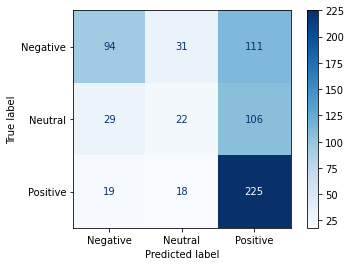




Performances Results with Subjective tweets for TB Naive Bayes
Model Performance metrics:

Accuracy: 0.4382
Precision: 0.4116
Recall: 0.4109
F1 Score: 0.4095


Model Classification report:
              precision    recall  f1-score   support

           0       0.48      0.46      0.47       236
           1       0.28      0.23      0.25       157
           2       0.47      0.55      0.51       262

    accuracy                           0.44       655
   macro avg       0.41      0.41      0.41       655
weighted avg       0.43      0.44      0.43       655



Prediction Confusion Matrix:


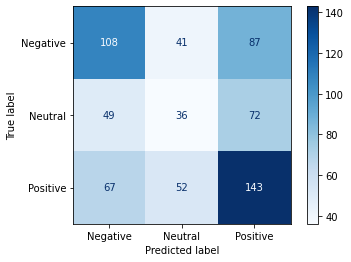




Performances Results with Subjective tweets for VADER
Model Performance metrics:

Accuracy: 0.5863
Precision: 0.6245
Recall: 0.5495
F1 Score: 0.5427


Model Classification report:
              precision    recall  f1-score   support

           0       0.75      0.38      0.50       236
           1       0.58      0.36      0.45       157
           2       0.54      0.91      0.68       262

    accuracy                           0.59       655
   macro avg       0.62      0.55      0.54       655
weighted avg       0.63      0.59      0.56       655



Prediction Confusion Matrix:


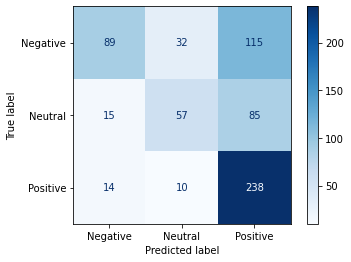

In [31]:
show_model_performance_results(trained_subjective_tweets_df, "Subjective tweets")

All tweets Performance Metrics!

Performances Results with All tweets for TB Patters
Model Performance metrics:

Accuracy: 0.5327
Precision: 0.5604
Recall: 0.5421
F1 Score: 0.5160


Model Classification report:
              precision    recall  f1-score   support

           0       0.66      0.27      0.39       351
           1       0.52      0.61      0.56       353
           2       0.51      0.75      0.60       304

    accuracy                           0.53      1008
   macro avg       0.56      0.54      0.52      1008
weighted avg       0.56      0.53      0.51      1008



Prediction Confusion Matrix:


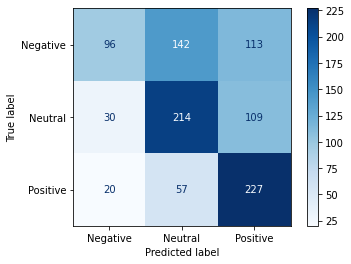




Performances Results with All tweets for TB Naive Bayes
Model Performance metrics:

Accuracy: 0.4018
Precision: 0.4005
Recall: 0.4072
F1 Score: 0.3936


Model Classification report:
              precision    recall  f1-score   support

           0       0.45      0.47      0.46       351
           1       0.38      0.23      0.29       353
           2       0.37      0.52      0.43       304

    accuracy                           0.40      1008
   macro avg       0.40      0.41      0.39      1008
weighted avg       0.40      0.40      0.39      1008



Prediction Confusion Matrix:


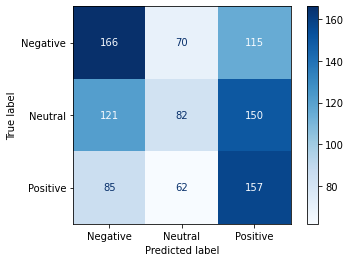




Performances Results with All tweets for VADER
Model Performance metrics:

Accuracy: 0.5734
Precision: 0.6120
Recall: 0.5866
F1 Score: 0.5597


Model Classification report:
              precision    recall  f1-score   support

           0       0.71      0.34      0.46       351
           1       0.63      0.56      0.59       353
           2       0.50      0.87      0.63       304

    accuracy                           0.57      1008
   macro avg       0.61      0.59      0.56      1008
weighted avg       0.62      0.57      0.56      1008



Prediction Confusion Matrix:


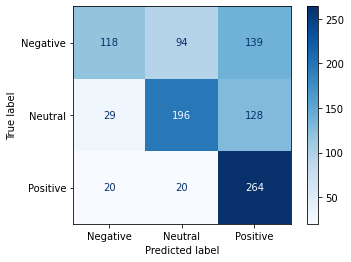

In [32]:
show_model_performance_results(trained_all_tweets_df, "All tweets")

## Oversampling using VADER Sentiment Analyser

There is a problem with the imbalanced dataset as there are much more negative tweets than neutral and positive ones, thus to minimise this problem, I used VADER to annotate some tweets and I chose neutral and/or positive ones only to annotate them by myself to increase the number of annotated tweets in those classes. Of course, the annotations are now slightly biased towards VADER. 

In [33]:
def do_oversampling(label: int, json_path: str, sample_size: int, path_to_save_sample: str, access_key: str="Tweet") -> pd.DataFrame:
    """
    This method is used to do oversampling using VADER for the given sentiment. 
    After making VADER predictions and choosing the ones which correspond to the wanted 
    sentiment, other columns different than Location, Publish Date and Tweet are retained.  
    """
    tweets_df = open_json_file(json_path)
    
    sample_df = tweets_df.sample(n=sample_size)

    sample_df["Sentiment"] = sentiment_labels["NEGATIVE"]
    
    sample_df = vader_sentiment_analyser(sample_df, access_key=access_key)

    sample_df = sample_df[sample_df["VADER Predictions"] == label]

    # Removed the prediction as I know that all of them are of specific class, but I removed the score as well
    # because some of them may have higher or lower probabilities, so I as an annotator may be more biased 
    # after seeing those numbers, so to reduce bias towards the classifier, I decided to not store those properties  
    if 'Corrected Tweet' in sample_df.columns:
        sample_df = sample_df.drop(columns=["Corrected Tweet", "VADER Predictions", "VADER compound"])
    else:
        sample_df = sample_df.drop(columns=["VADER Predictions", "VADER compound"])

    sample_df.to_json(path_to_save_sample, orient="records", indent=4)
    return sample_df


def do_oversampling_for_all_classes(json_path: str, sample_size: int, path_to_save_sample: str, sentiment_counts: dict, access_key: str="Tweet") -> pd.DataFrame:
    """
    This method is similar to 'do_oversampling' in a way that this does oversampling with 
    VADER, but it does not only for one class but for all classes, but different 
    number of samples is provided for each class. 
    """
    tweets_df = open_json_file(json_path)
    
    sample_df = tweets_df.sample(n=sample_size)

    # Set the default value 
    sample_df["Sentiment"] = sentiment_labels["NEGATIVE"]
    
    sample_df = vader_sentiment_analyser(sample_df, access_key=access_key)

    negative_tweets_df = sample_df[sample_df["VADER Predictions"] == -1].sample(sentiment_counts["NEGATIVE"])
    neutral_tweets_df = sample_df[sample_df["VADER Predictions"] == 0].sample(sentiment_counts["NEUTRAL"])
    positive_tweets_df = sample_df[sample_df["VADER Predictions"] == 1].sample(sentiment_counts["POSITIVE"])

    labelled_tweets_df = pd.concat([negative_tweets_df, neutral_tweets_df, positive_tweets_df], axis=0)
    labelled_tweets_df = labelled_tweets_df.sample(frac=1).reset_index(drop=True)

    # Removed the predictions, because I as an annotator may be more biased after seeing VADER predictions 
    # numbers, so to reduce bias towards the classifier, I decided to not store those properties  
    if 'Corrected Tweet' in labelled_tweets_df.columns:
        labelled_tweets_df = labelled_tweets_df.drop(columns=["Corrected Tweet", "VADER Predictions", "VADER compound"])
    else:
        labelled_tweets_df = labelled_tweets_df.drop(columns=["VADER Predictions", "VADER compound"])

    labelled_tweets_df.to_json(path_to_save_sample, orient="records", indent=4)
    return labelled_tweets_df


Uncomment the code below if you want to do oversampling of tweets which should be annotated for Sentiment Analysis. 

In [34]:
# sample_size = 1000
# path_to_save_sample = f"{BASE_PATH}/vader_annotated_tweets.json"
# sentiment_counts = {"NEGATIVE": 0, "NEUTRAL": 50, "POSITIVE": 50}

# vader_labelled_tweets_df = do_oversampling_for_all_classes(json_path=json_file_path, sample_size=sample_size, sentiment_counts=sentiment_counts, path_to_save_sample=path_to_save_sample)
# vader_labelled_tweets_df.head()

# Transformer Models

Import a fine tuned transformer model which will be used for further tasks to do like analysing the tweet sentiment consistency throughout the tweet. 

## Import the Fine-Tuned Model and Set up the Parameters and Constants


In [35]:
# Define a path inside the given directory
model_subdirectory_name = "model_save"
model_path = f"{BASE_PATH}/{model_subdirectory_name}"
 
batch_size = 64  # how many tweets are within one batch
random_state = 10  # to be able to reproduce results

tweets = tweets_df["Tweet"].values
labels = tweets_df["Sentiment"].values

In [36]:
def get_device() -> torch.device:
    """
    This method checks if GPU is available, if it is, then an object representing it is returned.
    Otherwise, CPU is utilised.  
    """
    if torch.cuda.is_available():    
        # Tell PyTorch to use the GPU.    
        device = torch.device("cuda")

        print(f'There are {torch.cuda.device_count()} GPU(s) available.')

        print(f'I will use the GPU: {torch.cuda.get_device_name(0)}')

    else:
        print('No GPU available, using the CPU instead.')
        device = torch.device("cpu")

    return device

In [37]:
# Get GPU or CPU
device = get_device()

# Load a trained model and vocabulary that I have fine-tuned
model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

# Copy the model to the GPU
_ = model.to(device)

No GPU available, using the CPU instead.


## Get the Length of the Longest Tweet in terms of the Number of Tokens

In [38]:
def plot_tweet_lengths(tweet_lengths: np.ndarray, max_len: int) -> None:
    """
    This method plots the number of tokens per each tweet using a matplotlib plot. 
    """
    print(f"Max length of tokens in tweets: {max_len}")
    counts = Counter(tweet_lengths)

    fig = plt.figure(figsize = (10, 7)) 
    plt.bar(list(counts.keys()), list(counts.values()))

    plt.xlabel("Tweet Tokens Number") 
    plt.ylabel("No. of Tweets of that Length ") 
    plt.title("Number of Tokens per Tweet") 

    plt.show()
    

def get_max_tweet_length(tweets: np.ndarray, tokenizer: AutoTokenizer) -> int:
    """
    This method finds the longest number of tokens across tweets. All tweets number of
    tokens are plotted in a diagram.   
    """
    max_len = 0

    tweet_lengths = np.zeros(len(tweets)) 

    for i, sent in enumerate(tweets):
        # Tokenize the text and add special tokens like [CLS] and [SEP]
        input_ids = tokenizer.encode(sent, add_special_tokens=True)

        tweet_length = len(input_ids)
        
        # Update the maximum sentence length
        max_len = max(max_len, tweet_length)

        tweet_lengths[i] = tweet_length
    
    plot_tweet_lengths(tweet_lengths, max_len)
    
    return max_len


## Inference with the Saved Model

In [39]:
def create_tweets_dataloader(tweets: np.ndarray, max_len: int, sampler: Sampler, batch_size: int, tokenizer: AutoTokenizer) -> DataLoader:
    """
    This method created a dataloader object given parameters max number of tokens, 
    type of the sampler, batch size and model's tokenizer.  
    """
    input_ids, attention_masks = encode_tweets(tweets, max_len, tokenizer)
    dataset = TensorDataset(input_ids, attention_masks)
    
    dataloader = DataLoader(
            dataset, 
            sampler = sampler(dataset), 
            batch_size = batch_size 
    )
    
    return dataloader


def encode_tweets(tweets: np.ndarray, max_len: int, tokenizer: AutoTokenizer) -> tuple:
    """
    This method tokenises each tweet with the given model tokenizer. It uses padding 
    and truncation if the tweets are too short or too long respectively. 
    Tokenised tweet representations are returned. 
    """
    input_ids = []
    attention_masks = []

    for tweet in tweets:
        encoded_dict = tokenizer.encode_plus(
                            tweet,                      
                            add_special_tokens = True,  # like [CLS]
                            max_length = max_len,           
                            padding='max_length',
                            return_attention_mask = True,  
                            truncation=True,  # truncate too long tweets
                            return_tensors = 'pt'  # Pytorch Tensors
                       )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
    
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks


def make_predictions(dataloader: DataLoader, device: torch.device, model: AutoModelForSequenceClassification) -> np.ndarray:
    """
    This method makes sentiment predictions for the whole dataset of tweets. Dataloader
    is iterated through to predict the results of a batch of tweets to not fill the whole 
    available memory.  
    """
    model.eval()

    predictions = []
    
    for batch in dataloader:
        # Obtain the model outputs for the given tweets
        logits = batch_predict(batch, device, model)
        predictions.append(logits)
    
    flat_predictions = np.concatenate(predictions, axis=0)

    # Convert model outputs to the predictions (the highest output corresponds to the model guess)
    # indices of outputs correspond to the class labels, as e.g. index 0 correspond to the class 0
    flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

    return flat_predictions

    
def batch_predict(batch: torch.Tensor, device: torch.device, model: AutoModelForSequenceClassification) -> np.ndarray:
    """
    Generate and return model predictions for the batch of tweets.
    """
    # Add to the device each tweet representation
    batch = tuple(t.to(device) for t in batch)
    
    b_input_ids, b_input_mask = batch

    # Generate model predictions without collecting gradient
    with torch.no_grad():
        result = model(b_input_ids, 
                     attention_mask=b_input_mask,
                     return_dict=True)

    logits = result.logits

    # Convert the Pytorch Tensor to numpy array
    logits = logits.detach().cpu().numpy()
    
    return logits


In [40]:
def do_inference(model: AutoModelForSequenceClassification, tokenizer: AutoTokenizer, max_len: int, tweets: np.ndarray, batch_size: int=batch_size) -> np.ndarray:
    """
    This method created a dataloader of the dataset of tweets which is used to iterate through it
    to make sentiment predictions using the given transformer model for given tweets.
    """
    dataloader = create_tweets_dataloader(tweets, max_len, SequentialSampler, batch_size, tokenizer)    

    predictions = make_predictions(dataloader, device, model)

    return predictions


This result of classification is not reliable as the model was trained of a part of this data, thus there is data leakage what should not be used in practice. However, I used it here just to observe of the model is working before using it on subsequent tasks.

Max length of tokens in tweets: 117


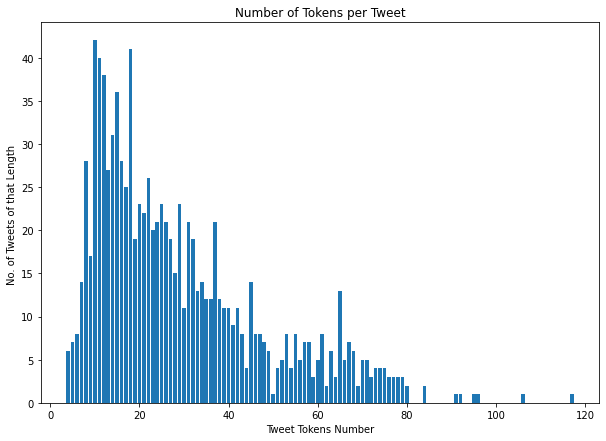

Accuracy is 78.87%


In [41]:
max_len = get_max_tweet_length(tweets, tokenizer)
predictions = do_inference(model, tokenizer, max_len, tweets)
accuracy = (labels == predictions).sum()/len(labels)
print(f"Accuracy is {accuracy*100:.2f}%")

# Analyse Tweets Sentiment Consistency by Splitting Tweet into Parts

## Split Tweets in Half

In [42]:
def get_split_tweets(tweets: np.ndarray, min_number_of_tokens: int=6) -> tuple:
    """
    This method takes an array of tweets and splits them into two parts if the tweet
    is of acceptable length.
    """
    num_of_tweets = len(tweets)
    first_halves, second_halves = list(), list()

    for i, tweet in enumerate(tweets):
        tokens = tweet.split()
        num_of_tokens = len(tokens)

        if num_of_tokens >= min_number_of_tokens:
            mid_point = (num_of_tokens - 1) // 2  
            first_halves.append(" ".join(tokens[:mid_point]))
            second_halves.append(" ".join(tokens[mid_point:]))

    return first_halves, second_halves


def get_half_tweets_agreement(first_halves: np.ndarray, second_halves: np.ndarray, model: AutoModelForSequenceClassification, tokenizer: AutoTokenizer, max_len: int, labels: np.ndarray) -> None:
    """
    This method takes tweets split into two parts by whitespaces, does transformer sentiment classification
    on them and find what is the agreement of sentiment across those parts with each other
    and the labels given for the whole tweets.
    """
    number_of_tweets = len(tweets)

    predictions_first = do_inference(model, tokenizer, max_len, first_halves)
    predictions_second = do_inference(model, tokenizer, max_len, second_halves)

    agreement_on_halves = 0
    agreement_on_first_half_with_truth = 0
    agreement_on_second_half_with_truth = 0
    agreement_on_all = 0

    for i, (first, second, label) in enumerate(zip(predictions_first, predictions_second, labels)):
        if first == second:
            agreement_on_halves += 1
        
        if first == label:
            agreement_on_first_half_with_truth += 1

        if label == second:
            agreement_on_second_half_with_truth += 1

        if label == first == second:
            agreement_on_all += 1

    return agreement_on_halves, agreement_on_first_half_with_truth, agreement_on_second_half_with_truth, agreement_on_all


In [43]:
def test_split_tweets_in_half(tweets: np.ndarray, labels: np.ndarray, name: str) -> None:
    """
    This methods gives statistics on the array of tweets two parts which agree to each other
    in terms of the sentiment.
    """
    print(f"Split in half! {name}!\n")

    number_of_tweets = len(tweets)

    first_halves, second_halves = get_split_tweets(tweets)
    number_of_tested_tweets = len(first_halves)

    agreement_on_halves, agreement_on_first_half_with_truth, agreement_on_second_half_with_truth, agreement_on_all = get_half_tweets_agreement(first_halves, second_halves, model, tokenizer, max_len, labels)

    print(f"In total tested tweets which are correctly labelled by the chosen model and satisfy the criteria of the length: {number_of_tested_tweets} out of {number_of_tweets} tweets")
    print(f"Agreement on both halves (not necessarily correct): {agreement_on_halves/number_of_tested_tweets*100:.2f}%")
    print(f"Agreement on the first half with the ground truth: {agreement_on_first_half_with_truth/number_of_tested_tweets*100:.2f}%")
    print(f"Agreement on the second half with the ground truth: {agreement_on_second_half_with_truth/number_of_tested_tweets*100:.2f}%")
    print(f"Agreement on both halves with the ground truth: {agreement_on_all/number_of_tested_tweets*100:.2f}%")

In [44]:
test_split_tweets_in_half(tweets, labels, "All annotated tweets")

Split in half! All annotated tweets!

In total tested tweets which are correctly labelled by the chosen model and satisfy the criteria of the length: 912 out of 1008 tweets
Agreement on both halves (not necessarily correct): 50.55%
Agreement on the first half with the ground truth: 33.00%
Agreement on the second half with the ground truth: 33.22%
Agreement on both halves with the ground truth: 16.34%


## Split by Contrasting Conjunctions

In [45]:
conjunctions = ["but", "however", "nevertheless", "because", "whereas", "although"] 

In [46]:
def get_split_by_conjunctions(tweets: np.ndarray, labels: np.ndarray, min_number_of_tokens: int=3) -> tuple:
    """
    This method splits tweets by whitespaces by given conjunctions into at least two parts. If there are none
    conjunctions in the sentence, then a tweet is skipped. If those parts are too short, then a tweet
    is also skipped. 
    """
    tweets_parts = list()
    labels_parts = list()
    pattern = " |".join(conjunctions)
    
    for tweet, label in zip(tweets, labels):
        # Split a tweet by given conjunctions
        sentences = re.split(pattern, tweet)
        
        # skip if after splitting there is only one part 
        if not sentences or len(sentences) == 1:
            continue
        
        # Collect all parts which meet length criteria
        final_sentences = list()

        for sentence in sentences:
            # may also use WhitespaceTokenizer or TweetTokenizer
            tokens = sentence.split()
            num_of_tokens = len(tokens)

            if min_number_of_tokens <= num_of_tokens:
                final_sentences.append(sentence)

        if len(final_sentences) >= 2:
            tweets_parts.append(final_sentences)
            labels_parts.append(label)

    return tweets_parts, labels_parts


def get_split_by_conjunction_tweets_agreement(tweets_parts: list, model: AutoModelForSequenceClassification, tokenizer: AutoTokenizer, max_len: int, labels: np.ndarray) -> tuple:
    """
    This method produces sentiment agreement between different parts of tweets which
    are split by conjunctions. Aggreement is produced whether they agree with each other 
    and the whole tweet sentiment.  
    """
    number_of_tweets = len(tweets)
    agreement_on_parts = 0
    agreement_on_all = 0
    
    # All splits of tweets are combined into one list which is used to produce labels
    # with a loaded model. Number of splits is needed to find out to which tweet a split
    # belongs to 
    number_of_splits_per_tweets = list()
    all_sentences = list()

    for sentences in tweets_parts:
        all_sentences.extend(sentences)
        number_of_splits_per_tweets.append(len(sentences))

    predictions = do_inference(model, tokenizer, max_len, all_sentences)

    index, tweet_index = 0, 0
    while index < len(predictions):
        tweet_predictions = predictions[index:index+number_of_splits_per_tweets[tweet_index]]

        # If tweet splits contains only one unique sentiment, then it means they agree 
        # with each other 
        if len(set(tweet_predictions)) == 1:
            agreement_on_parts += 1
        
        # If splits agree with each other and their sentiment is the same as with the whole 
        # tweet, then there is complete agreement within the tweet 
        if len(set(tweet_predictions)) == 1 and tweet_predictions[0] == labels[tweet_index]:
            agreement_on_all += 1
        
        index += number_of_splits_per_tweets[tweet_index]
        tweet_index += 1
    
    return agreement_on_parts, agreement_on_all


In [47]:
def test_split_tweets_by_conjunction(tweets: list, labels: list, name: str) -> None:
    """
    This method produces and displays statistics regarding agreement between tweet parts 
    which are produces by splitting the tweet with chosen conjunctions.
    """
    print(f"Split by conjunctions! {name}!\n")

    tweets_parts, labels_parts = get_split_by_conjunctions(tweets, labels)
    agreement_on_parts, agreement_on_all = get_split_by_conjunction_tweets_agreement(tweets_parts, model, tokenizer, max_len, labels_parts)

    number_of_tweets = len(tweets)
    number_of_tested_tweets = len(tweets_parts)

    print(f"In total tested tweets which are correctly labelled by the chosen model and satisfy the criteria of the length: {number_of_tested_tweets} out of {number_of_tweets} tweets")
    print(f"Agreement on all parts (not necessarily correct): {agreement_on_parts/number_of_tested_tweets*100:.2f}%")
    print(f"Agreement on all parts with the ground truth: {agreement_on_all/number_of_tested_tweets*100:.2f}%")


In [48]:
test_split_tweets_by_conjunction(tweets, labels, "All annotated tweets")

Split by conjunctions! All annotated tweets!

In total tested tweets which are correctly labelled by the chosen model and satisfy the criteria of the length: 134 out of 1008 tweets
Agreement on all parts (not necessarily correct): 42.54%
Agreement on all parts with the ground truth: 34.33%


## Test Splitting Consistency for a Random Sample with Predicted Seniments for Tweets

In [49]:
def test_random_sample_by_splitting(sample_size: int) -> None:
    """
    This method takes a random sample of tweets (number of them is provided as a parameter)
    and with them does two different splittings: 1) in half and 2) by conjunctions to 
    analyse the agreement of sentiments across the splits and the sentiment of the whole 
    tweet.
    """
    start_time = time.time()

    all_tweets_df = open_json_file(json_file_path)
    all_tweets_sample_df = all_tweets_df.sample(sample_size)

    tweets = all_tweets_sample_df["Tweet"].values

    max_len = get_max_tweet_length(tweets, tokenizer)
    predictions = do_inference(model, tokenizer, max_len, tweets)

    test_split_tweets_in_half(tweets, predictions, f"Random {sample_size} sample of tweets")
    print("\n")
    test_split_tweets_by_conjunction(tweets, predictions, f"Random {sample_size} sample of tweets")

    end_time = time.time() - start_time
    print(f"\nTime taken overall for testing splits: {end_time:.3f} s")


Max length of tokens in tweets: 100


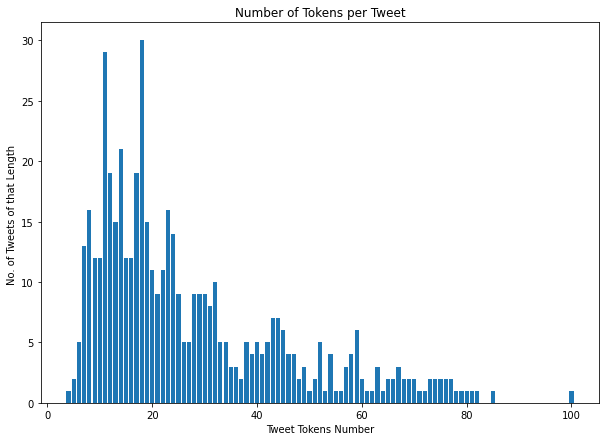

Split in half! Random 500 sample of tweets!

In total tested tweets which are correctly labelled by the chosen model and satisfy the criteria of the length: 446 out of 500 tweets
Agreement on both halves (not necessarily correct): 53.36%
Agreement on the first half with the ground truth: 40.13%
Agreement on the second half with the ground truth: 41.93%
Agreement on both halves with the ground truth: 23.32%


Split by conjunctions! Random 500 sample of tweets!

In total tested tweets which are correctly labelled by the chosen model and satisfy the criteria of the length: 60 out of 500 tweets
Agreement on all parts (not necessarily correct): 48.33%
Agreement on all parts with the ground truth: 43.33%

Time taken overall for testing splits: 552.108 s


In [50]:
test_random_sample_by_splitting(sample_size=500)

# Analyse Sentiment Distribution for Topic Labelled Tweets with Predicted Sentiments 

## Methods for Drawing a Time Series Graph and Finding the Sentiment Counts per Day

In [51]:
def get_sentiment_counts_per_day(tweets_df: pd.DataFrame, dates_df: pd.DataFrame) -> pd.DataFrame:
    """
    This method produces a dataframe which contains the number of each sentiment per every date 
    from the beginning of data collection till the end. 
    tweets_df contains all data regarding tweets.
    dates_df contains all dates from the beginning of data collection till the date when last 
        tweet was collected in the dataset as it is possible that there are none tweets of a sentiment some day.  
    """
    # Get counts of each sentiment per each date
    value_counts = tweets_df[['Date', 'Sentiment']].value_counts()
    counts_df = pd.DataFrame(value_counts)
    counts_df = counts_df.reset_index()

    dates = counts_df["Date"]
    
    # Reconstruct a dataframe to contain dates, sentiments and counts for a sentiment 
    # class per each date
    sentiments = counts_df["Sentiment"]
    counts = counts_df[0]
    data = {"Date": dates, "Sentiment": sentiments, "Count": counts}
    counts_df = pd.DataFrame(data)
    counts_df = counts_df.sort_values(by=['Date', 'Sentiment'])

    # Distribute counts according to the class label
    negative_counts_df = counts_df[counts_df["Sentiment"] == sentiment_labels["NEGATIVE"]].copy()
    neutral_counts_df = counts_df[counts_df["Sentiment"] == sentiment_labels["NEUTRAL"]].copy()
    positive_counts_df = counts_df[counts_df["Sentiment"] == sentiment_labels["POSITIVE"]].copy()
    
    # Use all possible unique dates as it is possible that none tweets were received for that day,
    # thus set 0 for such dates
    dates = dates_df["Date"]

    if len(negative_counts_df) != len(dates):
        negative_counts_df = pd.merge(negative_counts_df, dates_df, on="Date", how="right")
        negative_counts_df['Count'] = negative_counts_df['Count'].fillna(0)

    if len(neutral_counts_df) != len(dates):
        neutral_counts_df = pd.merge(neutral_counts_df, dates_df, on="Date", how="right")
        neutral_counts_df['Count'] = neutral_counts_df['Count'].fillna(0)

    if len(positive_counts_df) != len(dates):
        positive_counts_df = pd.merge(positive_counts_df, dates_df, on="Date", how="right")
        positive_counts_df['Count'] = positive_counts_df['Count'].fillna(0)

    # Construct the final dataframe with cleaned and redistributed data
    data = {"Date": dates, "Negative Counts": negative_counts_df["Count"].values, "Neutral Counts": neutral_counts_df["Count"].values, "Positive Counts": positive_counts_df["Count"].values}
    counts_df = pd.DataFrame(data)

    # Find the means for each class label per each date
    mean_neg, mean_neu, mean_pos = counts_df["Negative Counts"].mean(), counts_df["Neutral Counts"].mean(), counts_df["Positive Counts"].mean()
    print(f"Count Mean for the Negative Sentiments: {mean_neg:.2f} | Count Mean for the Neutral Sentiments: {mean_neu:.2f} | Count Mean for the Positive Sentiments: {mean_pos:.2f}")

    return counts_df

In [52]:
def draw_time_series_for_sentiments_per_day(counts_df: pd.DataFrame, name: str="") -> None: 
    """
    This method produces a plot which depicts all sentiments counts distribution over time.  
    """
    base_title = 'Sentiments Distribution by Date'
    title = base_title if name == "" else f"{base_title}: {name}"
    
    # 3 columns for each sentiment/class and 1 column for dates
    # For negative sentiment give red, neutral - blue and positive - green
    fig = px.line(counts_df, x="Date", y=counts_df.columns,
                hover_data={"Date": "|%B %d, %Y"},
                color_discrete_sequence=["red", "blue", "green"],
                title=title)
    
    fig.update_xaxes(tick0=counts_df["Date"][0], dtick="M1", tickformat="%d %b\n%Y")

    fig.show()
    

def draw_time_series_for_topics_per_day(counts_df: pd.DataFrame, name: str="") -> None: 
    """
    This method produces a plot which characterises topics sentiments counts distribution over time.  
    """
    base_title = 'Sentiments Distribution by Date'
    title = base_title if name == "" else f"{base_title}: {name}"
    
    fig = px.line(counts_df, x="Date", y=counts_df.columns,
        hover_data={"Date": "|%B %d, %Y"},
        title=title)
    
    fig.update_xaxes(tick0=counts_df["Date"][0], dtick="M1", tickformat="%d %b\n%Y")

    fig.show()


## Display Labelled Tweets Sentiments per Day (for All and Subjective Tweets Separately)

In [53]:
def display_predictions_for_all_tweets(predicted_tweets_file_path) -> pd.DataFrame:
    """
    This method provides a plot of tweets sentiments distribution over time for each sentiment class. 
    Also, it gives the mean count over time for each sentiment.    
    """
    predicted_tweets_df = open_json_file(predicted_tweets_file_path)
    predicted_tweets_df["Date"] = predicted_tweets_df["Publish Date"].apply(lambda date: datetime.fromtimestamp(int(date)/1000).strftime("%Y-%m-%d"))
    predicted_tweets_df = predicted_tweets_df.rename(columns={"Predicted Sentiment": "Sentiment"})

    unique_dates = sorted(predicted_tweets_df["Date"].unique())
    data = {"Date": unique_dates}
    dates_df = pd.DataFrame(data)

    print(predicted_tweets_df["Sentiment"].value_counts())

    counts_df = get_sentiment_counts_per_day(predicted_tweets_df, dates_df)

    draw_time_series_for_sentiments_per_day(counts_df, name="All Collected Tweets")

    return predicted_tweets_df


In [54]:
predicted_tweets_df = display_predictions_for_all_tweets(predicted_tweets_file_path=predicted_tweets_file_path)

0    453361
1    250129
2    115710
Name: Sentiment, dtype: int64
Count Mean for the Negative Sentiments: 4927.84 | Count Mean for the Neutral Sentiments: 2718.79 | Count Mean for the Positive Sentiments: 1257.72


In [55]:
def display_predictions_for_subjective_tweets(predicted_tweets_df: pd.DataFrame) -> None:
    """
    This method takes generated predicted tweets dataframe which is used to select 
    only subjective tweets. Then this method provides a plot of tweets sentiments distribution 
    over time for each sentiment class. Also, it gives the mean count over time for each sentiment.
    """
    unique_dates = sorted(predicted_tweets_df["Date"].unique())
    data = {"Date": unique_dates}
    dates_df = pd.DataFrame(data)

    _, subjective_predicted_tweets_df, _ = filter_subjective_tweets(predicted_tweets_df, threshold=0.1)
    print(subjective_predicted_tweets_df["Sentiment"].value_counts())

    subjective_counts_df = get_sentiment_counts_per_day(subjective_predicted_tweets_df, dates_df)

    draw_time_series_for_sentiments_per_day(subjective_counts_df, name="Subjective Tweets")


In [56]:
subjective_counts_df = display_predictions_for_subjective_tweets(predicted_tweets_df)

0    283883
1    105625
2     92885
Name: Sentiment, dtype: int64
Count Mean for the Negative Sentiments: 3085.68 | Count Mean for the Neutral Sentiments: 1148.10 | Count Mean for the Positive Sentiments: 1009.62


## Analyse the Distribution of Sentiments across Different Topics 

In [57]:
def read_labelled_topics_tweets() -> tuple:
    """
    This method reads two datasets - one is with sentiment predictions by the model and 
    the other with the same tweets with assigned topics. I need to merge them as they have 
    essential information for subsequent data analysis - one has sentiments and dates, the other - topic
    specific assigned data.
    """
    labelled_topics_tweets_df = open_json_file(predicted_topics_tweets_file_path)
    labelled_topics_tweets_df = labelled_topics_tweets_df.rename(columns={"Document":"Tweet"})

    topic_data = labelled_topics_tweets_df.groupby(["Topic", "Name"]).size().reset_index()

    # Skip topic -1 which contains all tweets which were not allocated to other topics 
    topic_ids = topic_data["Topic"].values[1:]
    topic_names = topic_data["Name"].values[1:]

    initial_topics_tweets_df = open_json_file(save_topic_tweets_paths)

    # Merge those two dataframes because I need dates from the second one as after 
    # topic allocation, the other properties are skipped  
    tweets = labelled_topics_tweets_df["Tweet"].values
    topics = labelled_topics_tweets_df["Topic"].values
    sentiments = labelled_topics_tweets_df["Predicted Sentiment"].values
    dates = initial_topics_tweets_df["Publish Date"].apply(lambda date: datetime.fromtimestamp(int(date)/1000).strftime("%Y-%m-%d")).values

    data = {"Tweet": tweets, "Topic": topics, "Sentiment": sentiments, "Date": dates}
    topics_tweets_df = pd.DataFrame(data)

    unique_dates = sorted(topics_tweets_df["Date"].unique())
    data = {"Date": unique_dates}
    dates_df = pd.DataFrame(data)

    return topics_tweets_df, dates_df, topic_ids, topic_names


In [58]:
topics_tweets_df, dates_df, topic_ids, topic_names = read_labelled_topics_tweets()
topics_tweets_df.head()

,Tweet,Topic,Sentiment,Date
0,Taehyung I'm feeling sick so i can't sleep. What about you? Why are you awake still?,0,0,2023-02-04
1,"Sleep deprivation can definitely lead to some fun GPose ideas.\n\nI give you, ""Le Paradis Perdu"" avec\n url",1,2,2022-12-21
2,i can’t sleep. i’m thinking abt my mom,-1,0,2022-12-27
3,"WE really in a clingy mood from the last remix in melatonin #HexLivewire , we stay clingy url",-1,0,2023-02-20
4,Ye u can’t sleep in bed rip,-1,0,2023-02-25


In [59]:
def display_sentiments_graph_for_topic(topic_ids: np.ndarray, topic_names: np.ndarray) -> list:
    """
    This method draws a sentiment count distribution graph over time for the given topics. 
    List of topic dataframes with sentiment counts per date is returned. 
    """
    topic_dfs = list()

    for topic_num, name in zip(topic_ids, topic_names):
        name = f"Topic {name}"
        topic_df = topics_tweets_df[topics_tweets_df["Topic"] == topic_num].copy()
        topic_df = topic_df.reset_index()
        topic_df = topic_df.drop(columns=["index", "Tweet", "Topic"])

        counts_df = get_sentiment_counts_per_day(topic_df, dates_df)
        topic_dfs.append(counts_df)

        draw_time_series_for_sentiments_per_day(counts_df, name=name)

    return topic_dfs


In [60]:
topic_dfs = display_sentiments_graph_for_topic(topic_ids, topic_names)

Count Mean for the Negative Sentiments: 424.35 | Count Mean for the Neutral Sentiments: 241.13 | Count Mean for the Positive Sentiments: 94.21


Count Mean for the Negative Sentiments: 62.92 | Count Mean for the Neutral Sentiments: 20.04 | Count Mean for the Positive Sentiments: 14.13


Count Mean for the Negative Sentiments: 8.05 | Count Mean for the Neutral Sentiments: 30.18 | Count Mean for the Positive Sentiments: 11.05


Count Mean for the Negative Sentiments: 14.34 | Count Mean for the Neutral Sentiments: 8.36 | Count Mean for the Positive Sentiments: 4.67


Count Mean for the Negative Sentiments: 12.79 | Count Mean for the Neutral Sentiments: 6.89 | Count Mean for the Positive Sentiments: 1.49


Count Mean for the Negative Sentiments: 10.00 | Count Mean for the Neutral Sentiments: 6.11 | Count Mean for the Positive Sentiments: 2.20


Count Mean for the Negative Sentiments: 8.68 | Count Mean for the Neutral Sentiments: 3.60 | Count Mean for the Positive Sentiments: 3.72


Count Mean for the Negative Sentiments: 8.04 | Count Mean for the Neutral Sentiments: 0.58 | Count Mean for the Positive Sentiments: 0.79


Count Mean for the Negative Sentiments: 2.48 | Count Mean for the Neutral Sentiments: 3.13 | Count Mean for the Positive Sentiments: 2.87


Count Mean for the Negative Sentiments: 2.91 | Count Mean for the Neutral Sentiments: 0.88 | Count Mean for the Positive Sentiments: 1.75


Count Mean for the Negative Sentiments: 1.36 | Count Mean for the Neutral Sentiments: 0.24 | Count Mean for the Positive Sentiments: 3.79


Count Mean for the Negative Sentiments: 2.20 | Count Mean for the Neutral Sentiments: 1.04 | Count Mean for the Positive Sentiments: 0.11


Count Mean for the Negative Sentiments: 1.36 | Count Mean for the Neutral Sentiments: 0.74 | Count Mean for the Positive Sentiments: 1.07


Count Mean for the Negative Sentiments: 2.02 | Count Mean for the Neutral Sentiments: 0.20 | Count Mean for the Positive Sentiments: 0.14


In [61]:
def display_all_topics_particular_sentiment(dates_df: pd.DataFrame, topic_dfs: pd.DataFrame, topic_names: np.ndarray) -> None:
    """
    This method produces a graph for each sentiment class showing the distribution of each
    topic counts distribution over time. 
    """
    negative_dfs = pd.DataFrame(dates_df.copy()) 
    neutral_dfs = pd.DataFrame(dates_df.copy()) 
    positive_dfs = pd.DataFrame(dates_df.copy()) 

    for topic_df, name in zip(topic_dfs, topic_names):
        negative_dfs[name] = topic_df["Negative Counts"].values
        neutral_dfs[name] = topic_df["Neutral Counts"].values
        positive_dfs[name] = topic_df["Positive Counts"].values

    draw_time_series_for_topics_per_day(negative_dfs, name="Negative Tweets for All Topics")
    draw_time_series_for_topics_per_day(neutral_dfs, name="Neutral Tweets for All Topics")
    draw_time_series_for_topics_per_day(positive_dfs, name="Positive Tweets for All Topics")


In [62]:
display_all_topics_particular_sentiment(dates_df, topic_dfs, topic_names)